In [30]:
%matplotlib inline

In [31]:
import argparse
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance
import pandas as pd
import seaborn as sns

import torch
import cpc.feature_loader as fl
import cpc.train as tr
from cpc.dataset import AudioBatchData, findAllSeqs, filterSeqs, parseSeqLabels

In [32]:
sys.path.append(os.path.dirname(tr.__file__))

In [33]:
onEncodings = True
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/zelasko-buck+ls/checkpoint_49.pt'
CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline2/checkpoint_49.pt'

In [34]:
cdata = fl.getCheckpointData(os.path.dirname(CP))
_, _, args = cdata
model, args.hiddenGar, args.hiddenEncoder = fl.loadModel([CP])
assert args.speakerEmbedding == 0

try:
    criterion = tr.loadCriterion(CP, model.gEncoder.DOWNSAMPLING, len(speakers), None)
except:
    criterion = None
    print("Failed to load criterion :(((())))")

Loading checkpoint /pio/scratch/1/i323106/wav2vec/runs/cpc/zelasko-buck+ls/checkpoint_49.pt
LocArgs: Namespace(CPCCTC=True, CPCCTCLearnBlank=False, CPCCTCLossTemp=1.0, CPCCTCMasq='', CPCCTCNoNegsMatchWin=False, CPCCTCNormalizeEncs=False, CPCCTCNormalizePreds=False, CPCCTCNumLevels=2, CPCCTCNumMatched=1, CPCCTCSelfLoop=False, CPCCTCSkipBeg=0, CPCCTCSkipEnd=0, CTC=False, CTCphones=False, NoARonRegHead=True, abspos=False, arMode='LSTM', batchSizeGPU=32, beta1=0.9, beta2=0.999, captureCPCCTCalign=False, captureCPCCTClogScores=False, captureConvRepr=False, captureCtxRepr=False, captureDSfreq=None, captureDStotNr=None, captureEachEpochs=10, captureEverything=False, capturePhoneAlign=False, capturePred=False, captureSetStats=None, captureSpeakerAlign=False, cpc_mode=None, debug=False, dropout=False, encodeSegments=False, encoder_type='cpc', epsilon=1e-08, file_extension=['.flac', '.wav'], gru_level=-1, headWeights=[1.0, 1.0], hiddenEncoder=256, hiddenGar=256, ignore_cache=True, learningRate=0

# Buckeye

In [35]:
phones2codes = {  # phonemes which should be the same for TIMIT
    'a': 0, 'aa': 1, 'aan': 2, 'ae': 3, 'aen': 4, 'ah': 0, 'ahn': 5, 'an': 5, 
    'ao': 6, 'aon': 7, 'aw': 8, 'awn': 9, 'ay': 10, 'ayn': 11, 'b': 12, 'ch': 13, 
    'd': 14, 'dh': 15, 'dx': 16, 'eh': 17, 'ehn': 18, 'el': 19, 'em': 20, 'en': 21, 
    'eng': 22, 'er': 23, 'ern': 24, 'ey': 25, 'eyn': 26, 'f': 27, 'g': 28, 'h': 29, 
    'hh': 29, 'hhn': 30, 'i': 31, 'id': 31, 'ih': 31, 'ihn': 32, 'iy': 33, 'iyih': 32, 
    'iyn': 32, 'jh': 34, 'k': 35, 'l': 36, 'm': 37, 'n': 38, 'ng': 39, 'nx': 40, 
    'ow': 41, 'own': 42, 'oy': 43, 'oyn': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 
    'sh': 49, 't': 50, 'th': 51, 'tq': 46, 'uh': 52, 'uhn': 53, 'uw': 54, 'uwix': 54, 
    'uwn': 55, 'v': 56, 'w': 57, 'y': 58, 'z': 59, 'zh': 60, '-': 61, '#': 62,
    'x': 63, 'no': 64
}

codes2phones = {v: k for k, v in phones2codes.items()}

In [36]:
args.pathDB = ['/pio/scratch/1/i323106/data/BUCKEYE/test/']
args.pathPhone = '/pio/scratch/1/i323106/data/BUCKEYE/converted_aligned_phones.txt'
args.size_window = 20480
args.file_extension = ['.wav']

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = seqNames[:1]
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))

5it [00:00, 1235.87it/s]


Saved cache file at /pio/scratch/1/i323106/data/BUCKEYE/test/_seqs_cache.txt


1it [00:00, 20460.02it/s]

Checking length...
Done, elapsed: 0.002 seconds
Scanned 1 sequences in 0.00 seconds
1 chunks computed


Joining pool
Joined process, elapsed=0.047 secs


In [45]:
model.cpu()
if criterion is not None:
    criterion.cpu()
valLoader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)
encodings = []
labels = []
for batchData, label in valLoader:
    with torch.no_grad():
        cFeature, encodedData, _ = model(batchData, None)
    encodings.append(encodedData.squeeze())
    # encodings.append(cFeature[0].squeeze())
    labels.append(label['phone'].squeeze())
encodings = torch.cat(encodings)
labels = torch.cat(labels)
print(encodings.size())
print(labels.size())

torch.Size([26752, 256])
torch.Size([26752])


In [86]:
labels[1:100]

tensor([61, 62, 62, 62, 62, 62, 62, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 58, 58, 58, 58, 58, 58, 58, 58, 58,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 62, 62, 62, 62, 58, 58, 58, 58, 58, 58, 58, 58, 58,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0])

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(encodings)
encodingsPCA = pca.transform(encodings)
encodingsPCA.shape

(26752, 50)

In [79]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, verbose=True, n_jobs=-1, n_iter=3000)
encodingsTsne = tsne.fit_transform(encodingsPCA)
encodingsTsne.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 26752 samples in 0.001s...
[t-SNE] Computed neighbors for 26752 samples in 57.593s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26752
[t-SNE] Computed conditional probabilities for sample 2000 / 26752
[t-SNE] Computed conditional probabilities for sample 3000 / 26752
[t-SNE] Computed conditional probabilities for sample 4000 / 26752
[t-SNE] Computed conditional probabilities for sample 5000 / 26752
[t-SNE] Computed conditional probabilities for sample 6000 / 26752
[t-SNE] Computed conditional probabilities for sample 7000 / 26752
[t-SNE] Computed conditional probabilities for sample 8000 / 26752
[t-SNE] Computed conditional probabilities for sample 9000 / 26752
[t-SNE] Computed conditional probabilities for sample 10000 / 26752
[t-SNE] Computed conditional probabilities for sample 11000 / 26752
[t-SNE] Computed conditional probabilities for sample 12000 / 26752
[t-SNE] Computed conditional probabilities for s

(26752, 2)

In [89]:
numClasses2Plot = 15
classes2Keep = pd.Series(labels).value_counts().index[:numClasses2Plot].tolist()

idxs2Keep = []
for i in range(len(labels)):
    if (labels[i] in classes2Keep) or (codes2phones[labels[i].item()][0] == 'l'):
        idxs2Keep.append(i)

x = encodingsTsne[idxs2Keep, :]
y = labels[idxs2Keep]

idxs2Keep = []
for i in range(len(y)):
    if codes2phones[y[i].item()][0] not in ['a', 'e', 'i', 'o', 'u']:
        idxs2Keep.append(i)

x = x[idxs2Keep, :]
y = y[idxs2Keep]

numClasses2Plot = len(np.unique(y))

z = []
for i in range(len(y)):
    z.append(codes2phones[y[i].item()])

/pio/scratch/1/i323106/miniconda3/envs/cpc37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

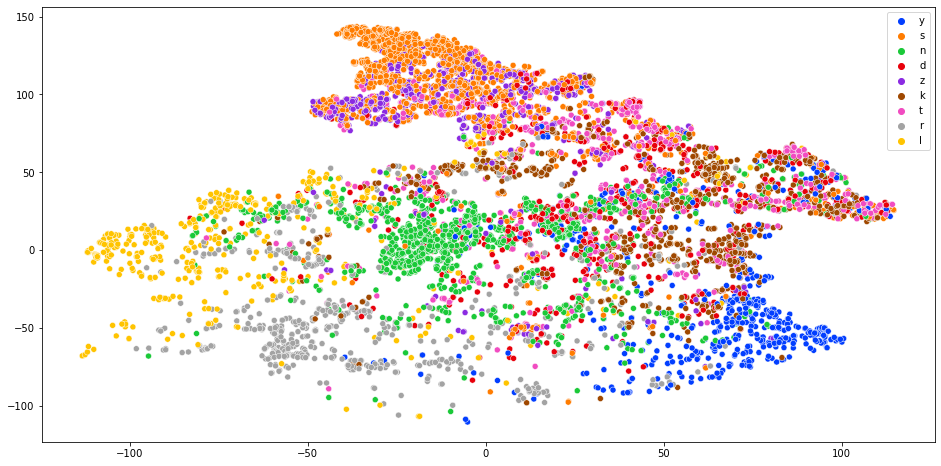

In [90]:
plt.figure(figsize=(16, 8))
sns.set_palette("bright", n_colors=numClasses2Plot)
sns.scatterplot(x[:,0], x[:,1], hue=z, legend='full', palette=sns.color_palette("bright", numClasses2Plot))

In [82]:
numClasses2Plot = 10
classes2Keep = pd.Series(labels).value_counts().index[:numClasses2Plot].tolist()

idxs2Keep = []
for i in range(len(labels)):
    if labels[i] in classes2Keep:
        idxs2Keep.append(i)

x = encodingsTsne[idxs2Keep, :]
y = labels[idxs2Keep]

idxs2Keep = []
for i in range(len(y)):
    if codes2phones[y[i].item()][0] in ['a', 'e', 'i', 'o', 'u']:
        idxs2Keep.append(i)

x = x[idxs2Keep, :]
y = y[idxs2Keep]

numClasses2Plot = len(np.unique(y))

z = []
for i in range(len(y)):
    z.append(codes2phones[y[i].item()])

/pio/scratch/1/i323106/miniconda3/envs/cpc37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

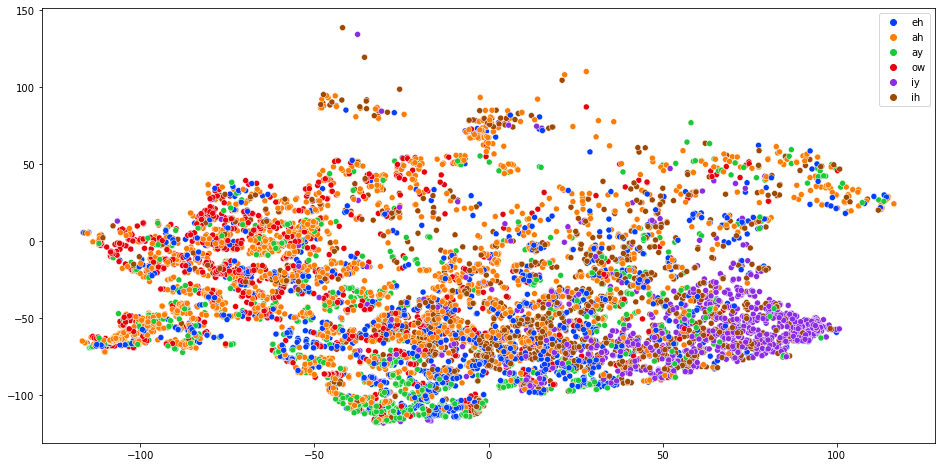

In [83]:
plt.figure(figsize=(16, 8))
sns.set_palette("bright", n_colors=numClasses2Plot)
sns.scatterplot(x[:,0], x[:,1], hue=z, legend='full', palette=sns.color_palette("bright", numClasses2Plot))